## **Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## **Loading and Cleansing data**

#### Loading Data

In [2]:
# Load data
df = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/TelecomCustomerChurn.csv')

#### Explore Data

In [3]:
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.isna().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.shape

(7043, 21)

In [9]:
df.columns

Index(['customerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

#### Cleansing Data

In [10]:
# Clean 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Drop irrelevant ID column
df = df.drop('customerID', axis=1)

# Split features
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
y.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

#### Imbalance Handling

In [12]:
# handle the imbalance data
ros = RandomOverSampler()
X,y = ros.fit_resample(X,y)

In [13]:
y.value_counts()

Churn
0    5174
1    5174
Name: count, dtype: int64

## **Type of Data**

In [14]:
# Identify categorical & numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


## **Preprocessing Data**

In [15]:
# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

## **Model**

In [16]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVC": SVC(),
    "MLP Classifier": MLPClassifier(max_iter=500)
}

# Store result as the list
results = []

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Evaluation Model without Kfold**

In [17]:
# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    
    # Create Pipeline for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    
    
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=6, scoring='accuracy')
    print(f"🧪 CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Fit the model result to the list 
    results.append(scores)
    print("📊 Test Set Report:")
    print(classification_report(y_test, y_pred))


🔍 Model: Logistic Regression
🧪 CV Accuracy: 0.7652 ± 0.0146
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1021
           1       0.77      0.81      0.79      1049

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070


🔍 Model: Random Forest
🧪 CV Accuracy: 0.8757 ± 0.0067
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1021
           1       0.86      0.95      0.91      1049

    accuracy                           0.90      2070
   macro avg       0.90      0.90      0.90      2070
weighted avg       0.90      0.90      0.90      2070


🔍 Model: Gradient Boosting
🧪 CV Accuracy: 0.7818 ± 0.0152
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1021
     

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:07] WARNI

🧪 CV Accuracy: 0.8449 ± 0.0122


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1021
           1       0.81      0.91      0.86      1049

    accuracy                           0.85      2070
   macro avg       0.86      0.85      0.85      2070
weighted avg       0.86      0.85      0.85      2070


🔍 Model: LightGBM
[LightGBM] [Info] Number of positive: 3437, number of negative: 3461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498260 -> initscore=-0.006959
[LightGBM] [Info] Start training from score -0.006959
[LightGBM] [Info] Number of positive: 3437, number of negative: 3461
[LightGBM] [

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3437, number of negative: 3461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498260 -> initscore=-0.006959
[LightGBM] [Info] Start training from score -0.006959
[LightGBM] [Info] Number of positive: 3438, number of negative: 3460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3438, number of negative: 3461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498333 -> initscore=-0.006668
[LightGBM] [Info] Start training from score -0.006668
[LightGBM] [Info] Number of positive: 3438, number of negative: 3461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 37
[LightGBM] [Info] [binary:

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🧪 CV Accuracy: 0.8219 ± 0.0162
[LightGBM] [Info] Number of positive: 4125, number of negative: 4153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498309 -> initscore=-0.006765
[LightGBM] [Info] Start training from score -0.006765
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1021
           1       0.80      0.90      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070


🔍 Model: K-Nearest Neighbors


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🧪 CV Accuracy: 0.7485 ± 0.0103
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      1021
           1       0.75      0.86      0.80      1049

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.78      2070
weighted avg       0.79      0.79      0.79      2070


🔍 Model: SVC
🧪 CV Accuracy: 0.7745 ± 0.0177
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1021
           1       0.78      0.82      0.80      1049

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.79      2070
weighted avg       0.79      0.79      0.79      2070


🔍 Model: MLP Classifier


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


🧪 CV Accuracy: 0.8102 ± 0.0117
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1021
           1       0.80      0.88      0.84      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



### **Viualization**

C:\Users\kmeanhor\AppData\Local\Temp\ipykernel_14636\1120433656.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


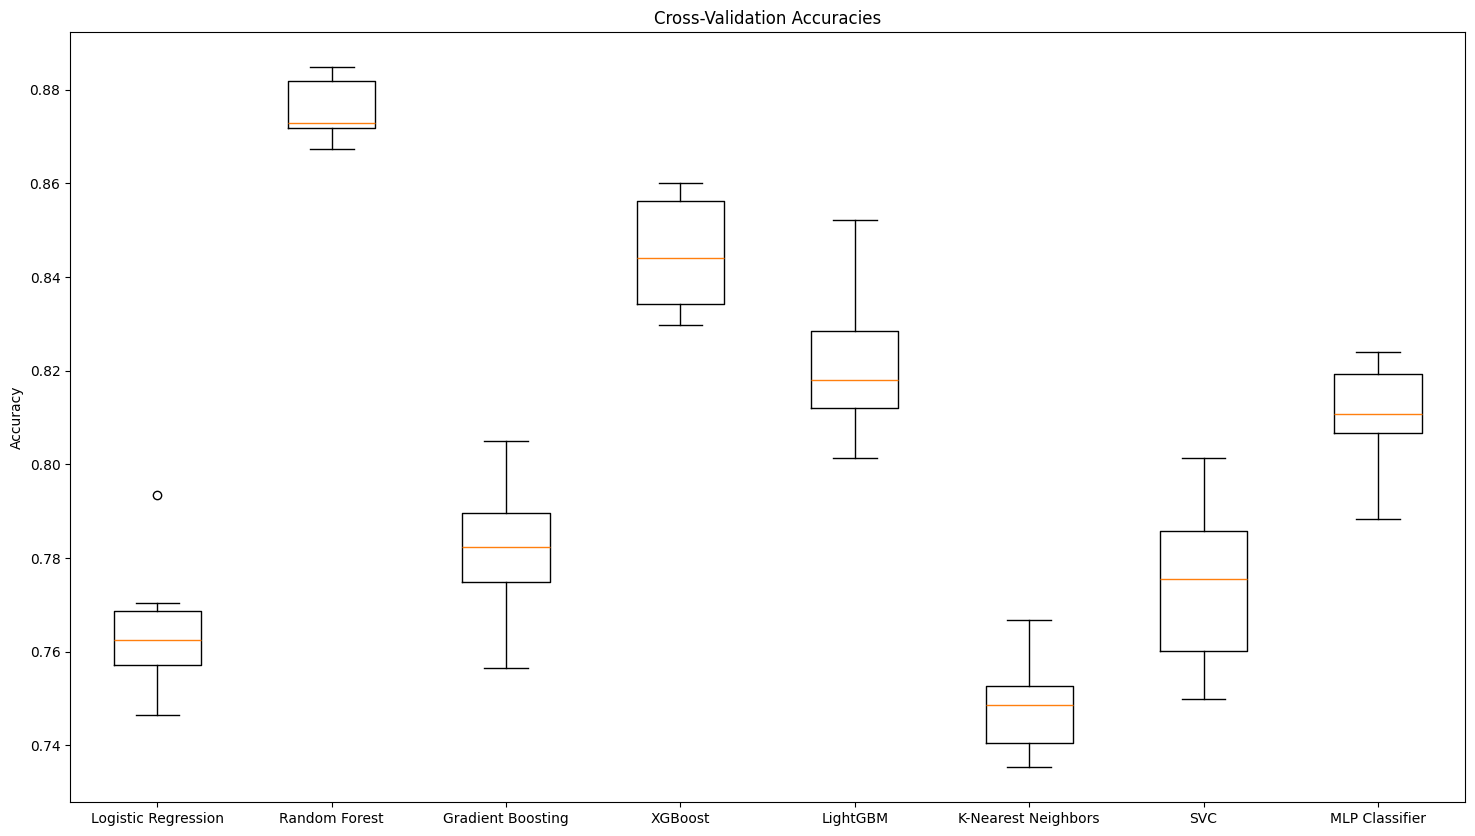

In [18]:
plt.figure(figsize=(18, 10))
plt.boxplot(results, labels=models.keys())
plt.title("Cross-Validation Accuracies")
plt.ylabel("Accuracy")
plt.show()

## **Evaluation Model with Kfold**

In [19]:
result_two = []

In [20]:
from sklearn.model_selection import KFold

# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    
    # Create Pipeline for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    print(f"🧪 CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Fit the model result to the list 
    result_two.append(scores)
    print("📊 Test Set Report:")
    print(classification_report(y_test, y_pred))


🔍 Model: Logistic Regression
🧪 CV Accuracy: 0.7649 ± 0.0040
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1021
           1       0.77      0.81      0.79      1049

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070


🔍 Model: Random Forest
🧪 CV Accuracy: 0.8758 ± 0.0064
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1021
           1       0.87      0.96      0.91      1049

    accuracy                           0.90      2070
   macro avg       0.91      0.90      0.90      2070
weighted avg       0.91      0.90      0.90      2070


🔍 Model: Gradient Boosting
🧪 CV Accuracy: 0.7842 ± 0.0077
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1021
     

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:51] WARNI

🧪 CV Accuracy: 0.8420 ± 0.0035


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1021
           1       0.81      0.91      0.86      1049

    accuracy                           0.85      2070
   macro avg       0.86      0.85      0.85      2070
weighted avg       0.86      0.85      0.85      2070


🔍 Model: LightGBM
[LightGBM] [Info] Number of positive: 3444, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499275 -> initscore=-0.002899
[LightGBM] [Info] Start training from score -0.002899


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3440, number of negative: 3458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498695 -> initscore=-0.005219
[LightGBM] [Info] Start training from score -0.005219


c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3438, number of negative: 3460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498405 -> initscore=-0.006379
[LightGBM] [Info] Start training from score -0.006379
[LightGBM] [Info] Number of positive: 3436, number of negative: 3462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6898, number of used features: 37
[LightGBM] [Info] [binary:

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3445, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499348 -> initscore=-0.002609
[LightGBM] [Info] Start training from score -0.002609
[LightGBM] [Info] Number of positive: 3422, number of negative: 3477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 37
[LightGBM] [Info] [binary:

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🧪 CV Accuracy: 0.8151 ± 0.0039
[LightGBM] [Info] Number of positive: 4125, number of negative: 4153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498309 -> initscore=-0.006765
[LightGBM] [Info] Start training from score -0.006765
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1021
           1       0.80      0.90      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070


🔍 Model: K-Nearest Neighbors
🧪 CV Accuracy: 0.7501 ± 0.0066
📊 Test S

c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


🧪 CV Accuracy: 0.8043 ± 0.0075
📊 Test Set Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1021
           1       0.81      0.86      0.83      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



c:\Users\kmeanhor\AppData\Local\anaconda3\envs\meanhorkea\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### **Viualization**

C:\Users\kmeanhor\AppData\Local\Temp\ipykernel_14636\4206963521.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result_two, labels=models.keys())


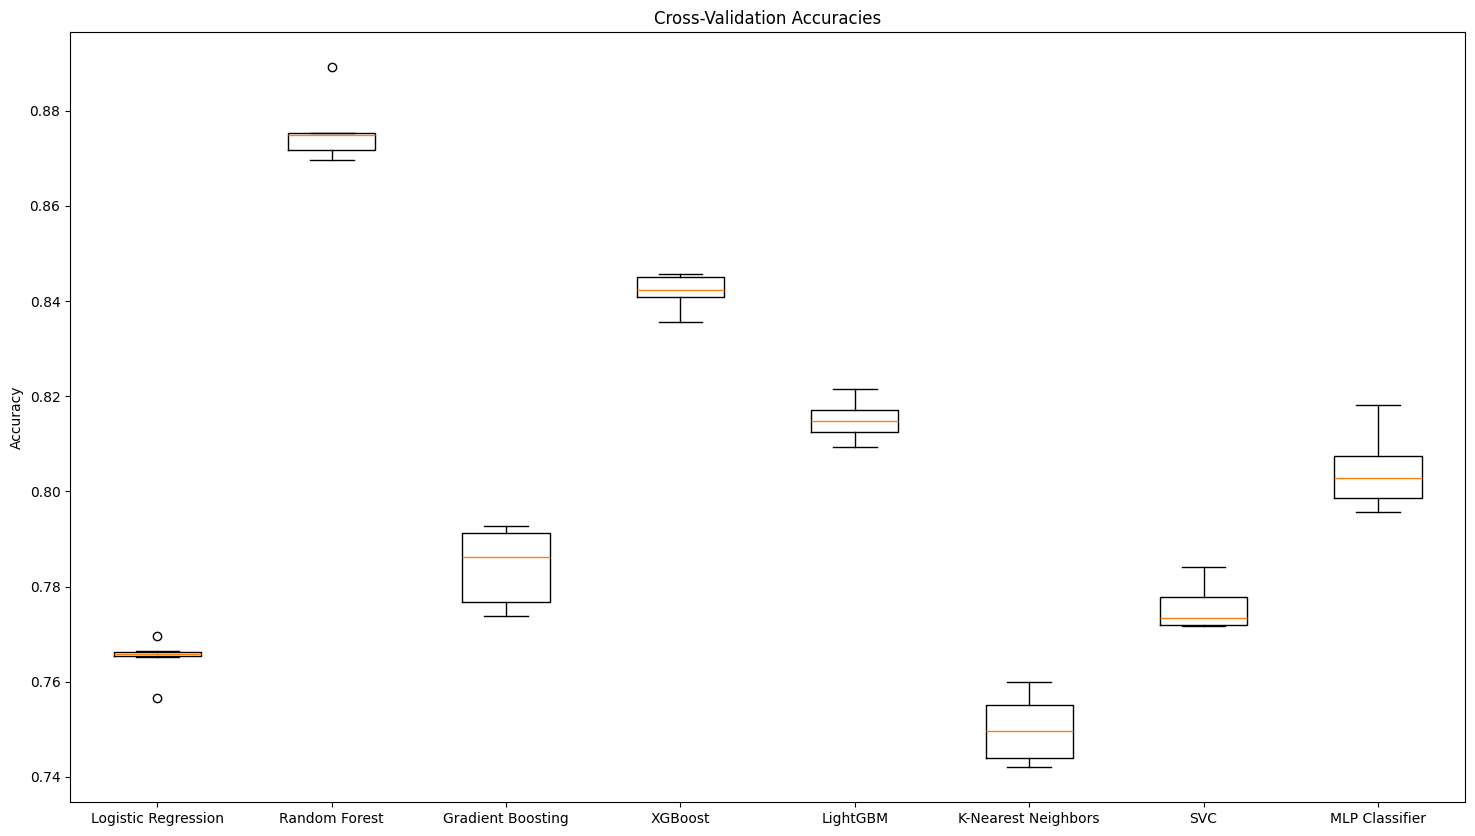

In [21]:
plt.figure(figsize=(18, 10))
plt.boxplot(result_two, labels=models.keys())
plt.title("Cross-Validation Accuracies")
plt.ylabel("Accuracy")
plt.show()

In [23]:
results

[array([0.77028986, 0.74637681, 0.7557971 , 0.79347826, 0.76359681,
        0.76142132]),
 array([0.88478261, 0.8673913 , 0.87318841, 0.88478261, 0.87164612,
        0.87237128]),
 array([0.78985507, 0.75652174, 0.77463768, 0.80507246, 0.78897752,
        0.77592458]),
 array([0.86014493, 0.82971014, 0.83115942, 0.86014493, 0.84336476,
        0.84481508]),
 array([0.83115942, 0.81086957, 0.80144928, 0.85217391, 0.81580856,
        0.82015954]),
 array([0.75217391, 0.73913043, 0.74492754, 0.76666667, 0.73531545,
        0.75271936]),
 array([0.7884058 , 0.75      , 0.7557971 , 0.80144928, 0.77810007,
        0.77302393]),
 array([0.82391304, 0.81449275, 0.80652174, 0.82101449, 0.78825236,
        0.8071066 ])]

In [24]:
result_two

[array([0.75652174, 0.76594203, 0.76956522, 0.76521739, 0.7657723 ,
        0.76649746]),
 array([0.87536232, 0.88913043, 0.86956522, 0.87536232, 0.87454677,
        0.87092096]),
 array([0.77463768, 0.78913043, 0.79275362, 0.78333333, 0.79187817,
        0.77374909]),
 array([0.84130435, 0.84565217, 0.83550725, 0.84057971, 0.84336476,
        0.84554025]),
 array([0.80942029, 0.81594203, 0.8173913 , 0.81376812, 0.81218274,
        0.82160986]),
 array([0.74202899, 0.74637681, 0.75289855, 0.7557971 , 0.75997099,
        0.74329224]),
 array([0.77173913, 0.77463768, 0.77173913, 0.78405797, 0.77882524,
        0.77229877]),
 array([0.79782609, 0.79565217, 0.81811594, 0.80434783, 0.80855693,
        0.80130529])]

## **Conclusion**

### 📊 Model Accuracy Scores (Mean) Comparison

| Model                | Without K-Fold | With K-Fold |
|---------------------|----------------|-------------|
| Logistic Regression | 0.765          | 0.765       |
| Random Forest       | 0.876          | 0.875       |
| Gradient Boosting   | 0.782          | 0.784       |
| XGBoost             | 0.845          | 0.842       |
| LightGBM            | 0.822          | 0.815       |
| KNN                 | 0.749          | 0.750       |
| SVC                 | 0.777          | 0.775       |
| MLP Classifier      | 0.810          | 0.804       |



---

### 🧠 Key Observations:

- **Random Forest** is consistently the top performer in both cases (~87.5% accuracy).
- **XGBoost** and **LightGBM** also perform well, slightly under Random Forest.
- **MLP Classifier** and **SVC** deliver solid and stable results.
- **KNN** and **Logistic Regression** show lower performance overall.
- The **difference between K-Fold and non-K-Fold results is minimal**, indicating that the dataset is likely well-balanced and representative, even without cross-validation.

---

### ✅ Conclusion:

The comparison of multiple machine learning classifiers demonstrates that **Random Forest** delivers the best performance, with **XGBoost** and **LightGBM** closely following. The minimal difference between K-Fold and standard validation indicates that the dataset is robust and not highly sensitive to sampling variations. For deployment or further optimization, **Random Forest** and **XGBoost** are strong candidates due to their high accuracy and consistency across validation strategies.
